In [22]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

In [251]:
import os
from prepare_data import get_data

catch_path=os.path.join('..','..','db1','catch.csv')
ext_path=os.path.join('..','..','db2','Ext.csv')
ext2_path=os.path.join('..','..','db2','Ext2.csv')

db1, db2 = get_data(catch_path,ext_path,ext2_path)

Prepare df_catch
Prepare df_ext
Prepare df_ext2


Make some new features

In [252]:
db2['id_fish']=db2['id_fish_x']

In [253]:
print('%s unique values in `id_regime`. Try get dummies' % len(db1['id_regime'].unique()))
df_regime_dummies = pd.get_dummies(db1['id_regime'])
df_regime_dummies.columns = ['regime%s'%col for col in df_regime_dummies.columns]

print('%s unique values in `id_region`. Try get dummies' % len(db1['id_region'].unique()))
df_region_dummies = pd.get_dummies(db1['id_region'])
df_region_dummies.columns = ['regime%s'%col for col in df_region_dummies.columns]
db1 = db1.drop(columns=['id_regime','id_region'])
db1 = pd.concat([db1,df_regime_dummies,df_region_dummies],axis=1)

10 unique values in `id_regime`. Try get dummies
50 unique values in `id_region`. Try get dummies


In [254]:
db2['hour_vsd']=db2['date_vsd_x'].astype('datetime64[ns]').dt.hour
prods = pd.DataFrame({'hour':range(1, 25)})

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
db2['date_session'] = pd.cut(db2['hour_vsd'], bins=b, labels=l, include_lowest=True)
session_dummies = pd.get_dummies(db2['date_session'])
df_db2=pd.concat([db2.drop(columns=['date_session']),session_dummies],axis=1)

In [255]:
df_db2.head()

,id_vsd,id_own,id_ves,date_fishery_x,id_Plat,id_fish_x,fish_x,volume_x,date_vsd_x,id_fish,hour_vsd,Late Night,Early Morning,Morning,Noon,Eve,Night
0,8660287,1175.0,1657.0,2022-05-24 00:00:00,6292428.0,292.0,треска,17.522,2022-05-24 17:31:35,292.0,17,0,0,0,0,1,0
1,8660287,1175.0,1657.0,2022-05-24 00:00:00,6292428.0,292.0,треска,17.522,2022-05-24 17:31:35,292.0,17,0,0,0,0,1,0
2,8502778,1011.0,1529.0,2022-05-24 00:00:00,6296383.0,400.0,минтай,72.665,2022-05-24 17:31:35,400.0,17,0,0,0,0,1,0
3,9345405,1236.0,1442.0,2022-05-24 00:00:00,6291814.0,292.0,треска,5.250,2022-05-24 20:40:39,292.0,20,0,0,0,0,1,0
4,9345405,1236.0,1442.0,2022-05-24 00:00:00,6291814.0,292.0,треска,5.250,2022-05-24 20:40:39,292.0,20,0,0,0,0,1,0


Group by id_ves

In [256]:
group_by = 'id_fish'

In [257]:
df_regime_dummies.columns

Index(['regime0', 'regime1', 'regime3', 'regime12', 'regime15', 'regime18',
       'regime22', 'regime41', 'regime61', 'regime97'],
      dtype='object')

In [258]:
df_group_1_regime_sum = db1[df_regime_dummies.columns]
df_group_1_region_sum = db1[df_region_dummies.columns]
df_group_1_sum=pd.concat([db1[group_by],df_group_1_regime_sum,df_group_1_region_sum], axis=1).groupby(group_by).sum()

In [259]:
df_group_1 = db1.groupby(group_by).agg({
    'id_own':['count', pd.Series.nunique],
    'id_ves': pd.Series.nunique,
    'id_fish': pd.Series.nunique,
    'catch_volume': ['mean','min','max','sum']
})

In [260]:
df_group_1.columns
df_group_1.drop(columns=(group_by, 'nunique'),inplace=True)

In [261]:
df_group_1=pd.concat([df_group_1,df_group_1_sum], axis=1)

In [262]:
df_group_2 = df_db2.groupby(group_by).agg({
    'id_own':['count', pd.Series.nunique],
    'id_ves': pd.Series.nunique,
    'id_fish': pd.Series.nunique,
    'id_Plat': pd.Series.nunique,
    'fish_x': pd.Series.nunique,
    'volume_x': ['mean','min','max','sum'],
    'Late Night': 'sum', 
    'Early Morning': 'sum', 
    'Morning': 'sum', 
    'Noon': 'sum', 
    'Eve': 'sum',
    'Night': 'sum'
})

In [263]:
df_group_2.drop(columns=(group_by, 'nunique'),inplace=True)

,"(id_own, count)","(id_own, nunique)","(id_ves, nunique)","(catch_volume, mean)","(catch_volume, min)","(catch_volume, max)","(catch_volume, sum)",regime0,regime1,regime3,...,volume_x_mean,volume_x_min,volume_x_max,volume_x_sum,Late Night_sum,Early Morning_sum,Morning_sum,Noon_sum,Eve_sum,Night_sum
id_fish,,,,,,,,,,,,,,,,,,,,,
6.0,79.0,5.0,8.0,13.081924,0.022,47.228,1033.472000,0.0,16.0,0.0,...,21.351896,0.022,51.203,1024.891,0.0,0.0,48.0,0.0,0.0,0.0
45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.085929,0.030,0.240,1.203,12.0,0.0,0.0,2.0,0.0,0.0
71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.265597,0.000,32325.000,79519.250,1500.0,8614.0,6545.0,1639.0,258.0,86.0
88.0,2300.0,43.0,76.0,1.491667,0.001,51.302,3430.834804,1.0,0.0,10.0,...,2.834297,0.000,65.055,7071.571,1374.0,193.0,736.0,165.0,18.0,9.0
90.0,75.0,3.0,5.0,0.792960,0.018,5.184,59.472000,0.0,0.0,0.0,...,0.786789,0.018,5.184,44.847,39.0,5.0,4.0,0.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927.0,18.0,2.0,2.0,1.649389,0.001,4.130,29.689000,0.0,14.0,4.0,...,9.673870,0.004,27.386,222.499,18.0,4.0,1.0,0.0,0.0,0.0
946.0,9.0,1.0,1.0,2.559333,0.871,5.078,23.034000,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
955.0,75.0,2.0,3.0,3.030240,0.027,31.455,227.268000,0.0,0.0,0.0,...,0.745875,0.036,2.826,11.934,13.0,3.0,0.0,0.0,0.0,0.0


In [264]:
df_group_2.columns = ['_'.join(col).strip()
    for col in df_group_2.columns.values]

In [265]:
df_group = pd.merge(df_group_1,df_group_2,how='outer',left_index=True, right_index=True)

Normalize values

In [267]:
df_group_db2_only = df_group[df_group['regime0'].isna()]
df_group_db1_only = df_group[df_group['volume_x_sum'].isna()]

In [268]:
df_group_1=df_group_db1_only[df_group_1.columns]
df_group_2 = df_group_db2_only[df_group_2.columns]
df_group_all = df_group.drop(df_group_1.index).drop(df_group_2.index)

/home/Kirill.Fomenko/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/Kirill.Fomenko/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


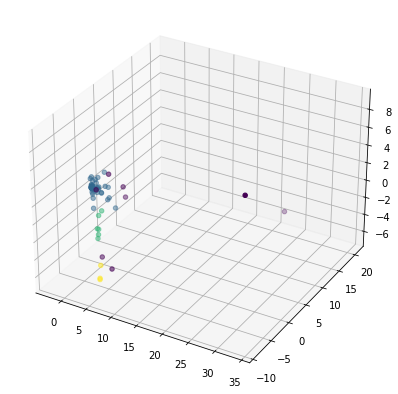

In [276]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(df_group_all)

pca = PCA (n_components=3)
X_reduced = pca.fit_transform(X_scale)

pred = DBSCAN(eps=1.8, min_samples=3).fit_predict(X_reduced)

fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(projection="3d")
x,y,z = [X_reduced[:,i] for i in range(3)]
ax.scatter(x,y,z, c=pred)
plt.show()

In [304]:
df_group_1.values

array([[  1.,   1.,   1., ...,   0.,   0.,   0.],
       [  5.,   2.,   2., ...,   1.,   1.,   0.],
       [492.,  12.,  18., ...,   0.,   0.,   1.],
       ...,
       [  9.,   1.,   1., ...,   0.,   0.,   0.],
       [  1.,   1.,   1., ...,   0.,   0.,   0.],
       [ 19.,   2.,   2., ...,   0.,   0.,   0.]])

In [327]:
df_groups=[df_group_1,df_group_2,df_group_all]
for df in df_groups:
    scaler = StandardScaler()
    X_scale = scaler.fit_transform(df.values)
    pca = PCA (n_components=3)
    X_reduced = pca.fit_transform(X_scale)
    pred = DBSCAN(eps=1.8, min_samples=3).fit_predict(X_reduced)
    values, counts = np.unique(pred, return_counts=True)
    most = values[np.argmax(counts)]
    df['anomaly']=[1 if each else 0 for each in pred!=most]
    df_group.loc[df.index,'anomaly']=df['anomaly']

/tmp/ipykernel_2340154/2870273099.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly']=[1 if each else 0 for each in pred!=most]
/tmp/ipykernel_2340154/2870273099.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly']=[1 if each else 0 for each in pred!=most]
